# Assignment 3: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_3_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [ ]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os

# Your code goes here for this section.
csv_path = os.path.join("housing.csv")
df = pd.read_csv(csv_path)
print(df)
print(df.info())
print(df['ocean_proximity'].value_counts())

       longitude  latitude  ...  median_house_value  ocean_proximity
0        -122.23     37.88  ...            452600.0         NEAR BAY
1        -122.22     37.86  ...            358500.0         NEAR BAY
2        -122.24     37.85  ...            352100.0         NEAR BAY
3        -122.25     37.85  ...            341300.0         NEAR BAY
4        -122.25     37.85  ...            342200.0         NEAR BAY
...          ...       ...  ...                 ...              ...
20635    -121.09     39.48  ...             78100.0           INLAND
20636    -121.21     39.49  ...             77100.0           INLAND
20637    -121.22     39.43  ...             92300.0           INLAND
20638    -121.32     39.43  ...             84700.0           INLAND
20639    -121.24     39.37  ...             89400.0           INLAND

[20640 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Co

<function matplotlib.pyplot.show>

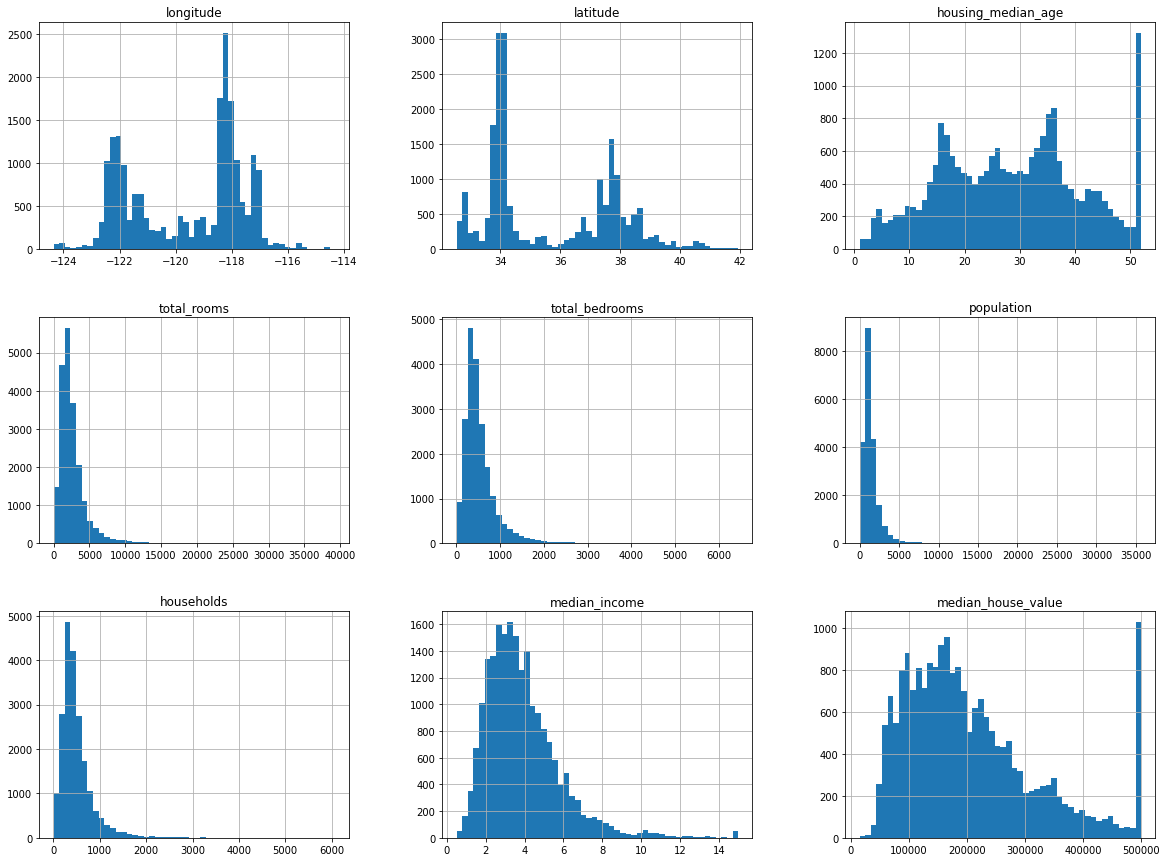

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show

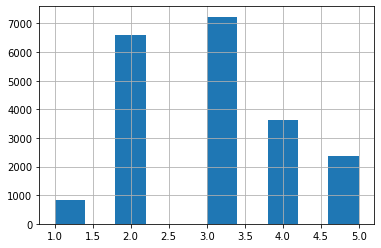

In [ ]:
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
df["income_cat"].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace=True)

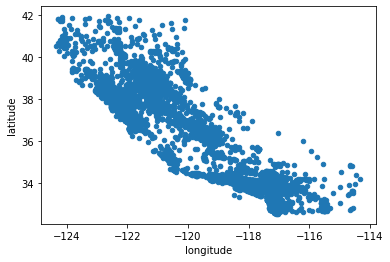

In [ ]:
# Make a copy of the stratified train set
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")

In [ ]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN


In [ ]:
#Cleaning the data
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
# When set to false, that feature will not be added --> so here it adds two features only
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_num = housing.drop("ocean_proximity", axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])



In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[0]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744,  0.68806755, -0.31205452,
       -0.08649871,  0.15531753,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

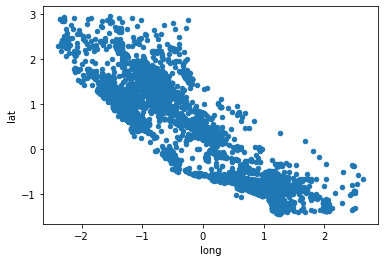

In [ ]:
xx = pd.DataFrame(housing_prepared)
xx
xx.columns = ['long', 'lat','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']

xx.plot(kind="scatter", x="long", y="lat")


- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).

import random
# print(labels.shape)
# def kMeanse(data, k, p):
#   centriod = []
#   for i in range(k):
#     centroid[i] = data[i]
class kMeans:
  def __init__(self, p=None):
    self.p = p
    self.k = None
    self.X = None
    self.centroid = []
    self.classes = []
    self.prev = []
    self.sse = []
    self.stdD = []
    
  def means(self, X, k):
    self.k = k 
    self.X = X
    count = 0
    for i in range(self.k): # set initial centroids to first kth observations
      #self.centroid.append(X[i*1000])
      self.centroid.append(X[random.randint(0,len(X))])
      self.sse.append(0)
    continueIterate = True
    while continueIterate: #and count <10 :
      count += 1
    #for i in range(10):
      self.classes = []
      self.stdD = []
      for j in range(self.k):
        self.classes.append([])
        self.stdD.append([])
        self.sse[j] = 0
      for m in self.X: # calculating and finding min distance from centroids
        dist = []
        euclidian = []
        for cent in self.centroid:
          dist.append(self.distance(m,cent))
          euclidian.append(self.ecDist(m,cent))
        self.classes[dist.index(min(dist))].append(m)
        self.sse[dist.index(min(dist))] += euclidian[dist.index(min(dist))]
      
      self.prev = self.centroid.copy()
      for clas in range(self.k): #recalculating centroids
        self.centroid[clas] = np.average(self.classes[clas],axis = 0)
        ph = pd.DataFrame(km.classes[clas])
        self.stdD[clas] = np.asarray(ph.std(axis = 0))
      continueIterate = self.checkSim(self.prev,self.centroid)
    self.classes = np.asarray(self.classes)
    self.stdD = np.asarray(self.stdD)

  def ecDist(self,x,y):
    dist = 0
    for q in range(len(x)):
      dist += pow(abs((x[q]-y[q])), 2)
    findist = dist
    return findist

  def distance(self, x, y):
    dist = 0
    if(self.p == 2):
      for q in range(len(x)):
        dist += pow(abs((x[q]-y[q])), self.p)
      findist = pow(dist, (1/self.p))
    if(self.p == 1):
      for q in range(len(x)):
        dist += abs(x[q]-y[q])
      findist = dist
    return findist

  def checkSim(self, x, y): #checks for when the numbers are equal/close enough
    b = False
    for i in range(len(x)):
      for j in range(len(x[i])):
        if abs(x[i][j])-abs(y[i][j])>.0001: 
          #return True
          b = True
    #return False
    return b
  
  def printSSE(self):
    for i in range(self.k):
      print('Cluster '+str(i)+': '+str(self.sse[i]))
      print('Standard Deviation: ')
      print(self.stdD[i])

  def plotK(self):
    colors = ['r','g','b','c','m','y','k','pink','gray','tab:orange','hotpink']
    ax = None
    for i in range(len(self.classes)):
      n = pd.DataFrame(km.classes[i])
      n.columns = ['long', 'lat','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']
      if i == 0:
        ax = n.plot(kind = 'scatter', x='long',y='lat', color = colors[i])
      else:
        n.plot(kind = 'scatter', x='long',y='lat', color = colors[i], ax = ax)
    for centroid in range(len(km.centroid)):
	    plt.scatter(km.centroid[centroid][0], km.centroid[centroid][1], s = 300,color = colors[i+1], marker = "x",linewidths = 10)

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


Cluster 0: 78554.64801923776
Standard Deviation: 
[0.50007099 0.48761629 1.05111733 0.70632174 0.70470471 0.69231736
 0.72811909 0.98101881 1.02003796 1.30713782 1.51471586 0.84706722
 0.37976615 0.49935006 0.         0.43669549 0.29322386]
Cluster 1: 100283.36077280244
Standard Deviation: 
[0.40532707 0.30967913 0.95860562 1.16800215 1.16215171 1.15990636
 1.15075814 1.01234614 0.97398227 0.6672462  0.11019761 1.09286237
 0.47895034 0.40027745 0.01461373 0.03863951 0.36126915]


'\n(CLUSTER THE DATA) :\n  The clusters that were found are centered near the highly populated areas of \nCalifornia. One cluster near San Fransico and another near Los Angeles. The data\nwas probably clustered the way it was since the homes one city are more similar to \neach other than when compared to homes in other cities. Also, it is possible the \ncentroids where placed near the two cities since the population of those areas\nare the highest in California. \n\n(CHANGE THE NUMBER OF CLUSTERS) :\nWhen the number of clusters increase, the house outliers become more noticable. Parts \nof cities that are not of norm or houses that are outside of the cities would be\ngrouped together and not with the city clusters. To a certain extent, adding more \nclusters will provide a more detailed idea of the different types of communities \n(ie the cities or new homes like in Silicon Valley). Also the SSE does get \nreduced due to there being more clusters. \nAs seen with the 10 cluster model,\n

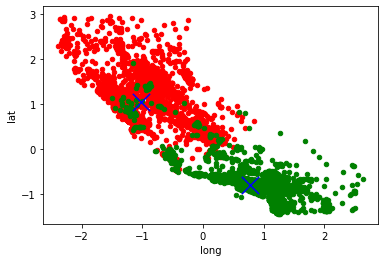

In [27]:
# Your code goes here
import math

km = kMeans(p=2)
km.means(X=housing_prepared, k=2)
km.plotK()
km.printSSE()
# Your paragraph goes here for this section
'''
(CLUSTER THE DATA) :
  The clusters that were found are centered near the highly populated areas of 
California. One cluster near San Fransico and another near Los Angeles. The data
was probably clustered the way it was since the homes one city are more similar to 
each other than when compared to homes in other cities. Also, it is possible the 
centroids where placed near the two cities since the population of those areas
are the highest in California. 

(CHANGE THE NUMBER OF CLUSTERS) :
When the number of clusters increase, the house outliers become more noticable. Parts 
of cities that are not of norm or houses that are outside of the cities would be
grouped together and not with the city clusters. To a certain extent, adding more 
clusters will provide a more detailed idea of the different types of communities 
(ie the cities or new homes like in Silicon Valley). Also the SSE does get 
reduced due to there being more clusters. 
As seen with the 10 cluster model,
the kmeans model, I believe does group silicon valley from San Fransisco with green 
being SF and grey being SV. However, the model is not perfectly clustering
in either cases as there are still plenty of outliers or just not grouped perfectly. 
'''

Cluster 0: 67753.19446203382
Standard Deviation: 
[0.49234702 0.4710671  1.04642026 0.52769804 0.5405273  0.53920012
 0.55498145 0.98509427 1.02255364 1.34706253 1.47420543 0.85230341
 0.37758007 0.49929667 0.         0.43904258 0.29229508]
Cluster 1: 55250.04144845479
Standard Deviation: 
[0.37301669 0.26503194 0.91679636 0.49974627 0.53427674 0.5753713
 0.53375501 1.01488616 0.98023075 0.65340045 0.48434319 1.10108932
 0.47737477 0.39299498 0.01543493 0.         0.36673394]
Cluster 2: 23853.943036719254
Standard Deviation: 
[0.96048916 0.89492782 0.71531783 1.72296234 1.54993518 1.73072656
 1.52981903 0.95251599 0.94181346 0.66608988 0.05962021 0.94632587
 0.49953899 0.47673831 0.         0.25879177 0.30581045]


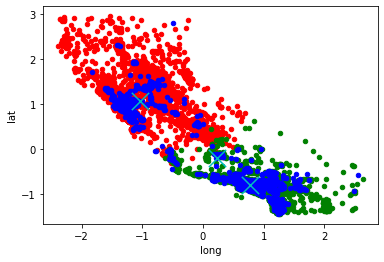

In [ ]:
km = kMeans(2)
km.means(housing_prepared, 3)
km.plotK()

km.printSSE()

Cluster 0: 26875.947157729446
Standard Deviation: 
[0.89333774 0.77716333 0.95176384 0.65954391 0.54307643 0.53054339
 0.54483918 1.12270634 0.87199487 2.00089297 0.08130499 0.43249511
 0.47658605 0.30291546 0.         0.26557657 0.375712  ]
Cluster 1: 33318.096682664494
Standard Deviation: 
[0.57077352 0.60800418 0.64365895 0.54870577 0.58063744 0.62074297
 0.6031515  0.64699775 0.58266741 0.77460587 2.12960335 0.60992466
 0.36056543 0.44590891 0.         0.25956712 0.21273663]
Cluster 2: 20296.984859370063
Standard Deviation: 
[0.963341   0.89004914 0.69877271 1.79291314 1.59070225 1.80823582
 1.57700461 0.82764239 0.8674033  0.64848718 0.059166   0.90244816
 0.49855352 0.48105241 0.         0.26952833 0.29866676]
Cluster 3: 11822.911372353015
Standard Deviation: 
[0.34241147 0.34569194 0.66069076 0.41524364 0.49261738 0.42089625
 0.50404781 0.67859795 0.96675798 0.39108354 0.06902926 0.91255987
 0.34965642 0.41495672 0.         0.50009566 0.34444604]
Cluster 4: 32739.00010816519
Sta

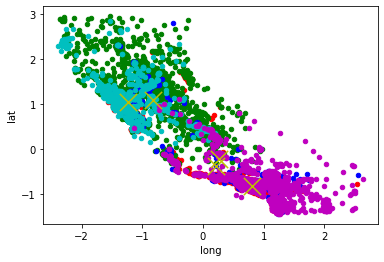

In [ ]:
km = kMeans(2)
km.means(housing_prepared, 5)
km.plotK()
km.printSSE()

Cluster 0: 30576.135908601056
Standard Deviation: 
[0.42333737 0.35457293 0.84405902 0.36530608 0.50945555 0.60443716
 0.51327762 0.3955353  0.58291182 0.327031   1.97310341 1.35248478
 0.48947498 0.4166208  0.01707967 0.02957423 0.37829136]
Cluster 1: 5609.2995456705685
Standard Deviation: 
[0.94310319 0.91048451 0.61520648 2.32706915 1.90534278 2.59503031
 1.90430515 0.784204   0.81276537 0.53022536 0.06181675 0.89843674
 0.49096643 0.49919244 0.         0.25496773 0.26219995]
Cluster 2: 10726.71533846185
Standard Deviation: 
[0.29332191 0.32444964 0.67782532 0.42581557 0.49943578 0.43942076
 0.50968782 0.65080182 0.93048927 0.37225694 0.40397942 0.79957718
 0.37009619 0.36554824 0.         0.499483   0.35968717]
Cluster 3: 16666.773188857984
Standard Deviation: 
[0.56926762 0.60477166 0.6796707  0.47851572 0.48813105 0.51949113
 0.50235032 0.63700813 0.53372714 0.75864127 0.88604722 0.57593036
 0.33390581 0.41551691 0.         0.23574948 0.18370265]
Cluster 4: 14098.42935512282
Stan

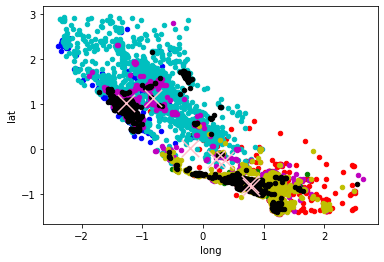

In [ ]:
km = kMeans(2)
km.means(housing_prepared, 7)
km.plotK()
km.printSSE()

Cluster 0: 10002.138264714233
Standard Deviation: 
[0.58085382 0.6195045  0.85041289 0.34360182 0.37263647 0.38976414
 0.37763935 0.56310473 0.40263684 0.77802558 0.07085293 0.56654221
 0.23324274 0.32855308 0.         0.19150266 0.16276284]
Cluster 1: 7496.445762326045
Standard Deviation: 
[0.19410992 0.24481153 0.7293832  0.37595723 0.43558479 0.37218945
 0.44437774 0.67767124 0.9033888  0.37575765 0.06080674 0.64347462
 0.38829126 0.2277807  0.         0.48979578 0.36592457]
Cluster 2: 6310.44056491956
Standard Deviation: 
[0.93251821 0.87462562 0.69300929 0.87715766 0.83204317 0.92861732
 0.77308462 0.87926151 0.90754231 0.67854284 0.0565647  0.83434645
 0.49922058 0.48330563 0.         0.25418964 0.29109312]
Cluster 3: 3670.4025290251384
Standard Deviation: 
[0.9384464  0.91031089 0.56087761 2.41778905 1.96263063 2.84248939
 1.84505234 0.80895646 0.82315732 0.48034322 0.06253805 0.78350238
 0.49997503 0.48346963 0.         0.2682738  0.29916809]
Cluster 4: 9175.001354293696
Standa

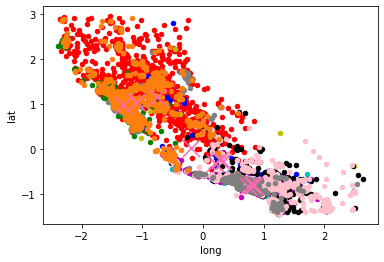

In [22]:
km = kMeans(2)
km.means(housing_prepared, 10)
km.plotK()
km.printSSE()

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



The housing crisis problem, should have at least the amount of major cities or points of population in Califorina as the number of clusters. This is because if we have fewer than that, the clusters would often merge cities with similar housing conditions into one giant cluster. By forcing the algorithm to cluster with at least the number of major population areas, KMeans will be able to split large clusters based on their latitude and longitude, giving a more accurate cluster. Also, for the outlier communities, it would be best to account for them with smaller amounts of clusters. This is because if we account for every single small community, it would cause the Kmeans to have to much clusters and cause an overfitting issue when clustering. The number have seen that would be maybe 10 clusters. This is because 7 clusters do not split between San Fransisco and Silicon Valley, however 10 does split the two into separate clusters. I believe this is a good indicator that 10 is a better number of clusters.
A possible solution is for California to permit in building complexes or apt buildings in masses around dense areas as well as out of the cities to drive the supply from demand. This could potentially lower prices as no one could afford purchasing them at the current prices. We see dense areas in the major cities, and there is still a need for more housing there. Expanding the available amounts of housing near those areas could provide for competition for other houses with insane prices. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 3:...".

Best of luck and have fun!